In [ ]:
!pip install nbimporter

In [1]:
import numpy as np
import pandas as pd
import nbimporter 
import matrix_factorization
np.random.seed(0)

Importing Jupyter notebook from matrix_factorization.ipynb


In [2]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [3]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [4]:
ratings_list = [i.strip().split("::") for i in open('./ml-1m/ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('./ml-1m/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('./ml-1m/movies.dat', 'r').readlines()]

ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [5]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
R_df.shape

(6040, 3706)

In [7]:
np.array(R_df.values, dtype=int)

array([[5, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [9]:
# names = ['user_id', 'item_id', 'rating', 'timestamp']
# df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
# df.head()

In [10]:
# n_users = df.user_id.unique().shape[0]
# n_items = df.item_id.unique().shape[0]
# ratings = np.zeros((n_users, n_items))
# for row in df.itertuples():
#     ratings[row[1]-1, row[2]-1] = row[3]
# ratings

In [11]:
ratings = np.array(R_df.values, dtype=int)
n_users = ratings.shape[0]
n_items = ratings.shape[1]

In [12]:
def get_sparsity(mat):
    print (str(n_users) + ' users')
    print (str(n_items) + ' items')
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [13]:
print ('Sparsity: {:4.2f}%'.format(get_sparsity(ratings)))

6040 users
3706 items
Sparsity: 4.47%


In [14]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], size=20, replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
    
#     print(test)
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [15]:
train, test = train_test_split(ratings)

In [16]:
train.shape

(6040, 3706)

In [17]:
test.shape

(6040, 3706)

In [18]:
ratings

array([[5, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
get_sparsity(ratings)

6040 users
3706 items


4.468362562231285

In [20]:
get_sparsity(train)

6040 users
3706 items


3.9286971547839014

In [21]:
get_sparsity(test)

6040 users
3706 items


0.5396654074473827

In [22]:
MF_SGD = matrix_factorization.ExplicitMF(train, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [10]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 10
	current iteration: 10
Train mse: 0.8264795643096374
Test mse: 0.9051574489352089


##################################################################################################################

# ####################################### GANS ###################################################

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
import torchvision.datasets as datasets
from torchvision import transforms

In [24]:
batch_size = 5

In [25]:
def make_some_noise(batch_size):
    return torch.rand(batch_size,100)

In [26]:
make_some_noise(batch_size)

tensor([[8.9087e-01, 4.7166e-01, 7.6108e-01, 2.7818e-01, 9.5874e-01, 2.7619e-01,
         8.3122e-01, 9.0605e-01, 4.2493e-01, 4.0727e-01, 5.2870e-01, 1.4785e-01,
         1.5160e-01, 2.6766e-02, 3.1058e-02, 3.3942e-01, 1.9594e-01, 7.4117e-01,
         7.2004e-01, 1.9824e-01, 4.1355e-01, 4.4217e-01, 8.7193e-01, 8.2988e-01,
         2.2405e-01, 3.7741e-01, 3.7660e-01, 4.4117e-01, 4.7020e-01, 9.1860e-02,
         8.5103e-01, 5.4650e-01, 8.2742e-01, 3.1776e-01, 2.5469e-01, 8.1883e-01,
         9.1414e-01, 6.6872e-01, 5.9061e-01, 4.4882e-01, 5.3474e-01, 5.7775e-01,
         3.8003e-01, 5.5922e-01, 1.6179e-01, 5.0391e-01, 2.1573e-02, 1.0553e-01,
         7.2259e-01, 2.0022e-01, 7.4842e-01, 6.6126e-01, 3.1551e-01, 7.3413e-01,
         3.5438e-01, 4.7352e-01, 2.5282e-01, 2.2805e-03, 1.7384e-01, 3.2439e-01,
         7.3955e-03, 2.6023e-01, 7.0651e-01, 8.8252e-01, 2.5503e-01, 7.3282e-01,
         5.6168e-02, 3.2593e-01, 7.4102e-01, 6.9155e-01, 9.0352e-01, 7.7082e-01,
         6.9165e-01, 8.0436e

In [27]:
# defining generator class

class generator(nn.Module):
    
    def __init__(self, inp, out):
        
        super(generator, self).__init__()
        
        self.net = nn.Sequential(
                                 nn.Linear(inp,300),
                                 nn.Tanh(),
                                 nn.Linear(300,1000),
                                 nn.Tanh(),
                                 nn.Linear(1000,800),
                                 nn.Tanh(),
                                 nn.Linear(800,out),
                                 nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.net(x)
        return x*5 # to get values in range [0,5]

In [28]:
# defining discriminator class

class discriminator(nn.Module):
    
    def __init__(self, inp, out):
        
        super(discriminator, self).__init__()
        
        self.net = nn.Sequential(
                                 nn.Linear(inp,300),
                                 nn.Tanh(),
                                 nn.Linear(300,300),
                                 nn.Tanh(),
                                 nn.Linear(300,200),
                                 nn.Tanh(),
                                 nn.Linear(200,out),
                                 nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [29]:
dis = discriminator(ratings.shape[1], 1)
gen = generator(100, ratings.shape[1])

In [30]:
dis

discriminator(
  (net): Sequential(
    (0): Linear(in_features=3706, out_features=300, bias=True)
    (1): Tanh()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): Tanh()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [31]:
gen

generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): Tanh()
    (2): Linear(in_features=300, out_features=1000, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1000, out_features=800, bias=True)
    (5): Tanh()
    (6): Linear(in_features=800, out_features=3706, bias=True)
    (7): Sigmoid()
  )
)

In [32]:
d_steps = 300
g_steps = 300

criteriond1 = nn.BCELoss()
optimizerd1 = optim.SGD(dis.parameters(), lr=0.0001, momentum=0.9)

criteriond2 = nn.BCELoss()
optimizerd2 = optim.SGD(gen.parameters(), lr=0.0001, momentum=0.9)

# printing_steps = 200

epochs = 50

In [33]:
def get_random_batch(mat, batch_size=16):
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]
    
get_random_batch(train)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [34]:
train = torch.autograd.Variable(torch.Tensor(train))

In [35]:
def d_my(x_r, x_g):
    return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r))

In [36]:
import torch.nn.functional as F
eval_losses = []
for epoch in range(10):
#     print (epoch)

    # training discriminator
    gen.train()
    dis.train()
    for d_step in range(d_steps):
        dis.zero_grad()
        
        # training discriminator on real data
        real_rows = get_random_batch(train, batch_size)
        discriminator_real_outputs = dis(real_rows)
   
        dis_real_loss = criteriond1(discriminator_real_outputs, Variable(torch.ones(batch_size,1)))
    
        dis_real_loss.backward()

        # training discriminator on data produced by generator
        z_vector = make_some_noise(batch_size)
        #output from generator is generated        
        fake_rows = gen(z_vector).detach()
#         print(fake_rows[:20])
        dis_fake_out = dis(fake_rows)
        dis_fake_loss = criteriond1(dis_fake_out, Variable(torch.zeros(batch_size,1)))
        dis_fake_loss.backward()

        optimizerd1.step()
        
    # training generator
    for g_step in range(g_steps):
        gen.zero_grad()
        
        #generating data for input for generator
        z_vector = make_some_noise(batch_size)
        
        fake_rows = gen(z_vector)
#         print(fake_rows.shape, z_vector.shape)
#         print(fake_rows[:20])
        dis_out_gen_training = dis(fake_rows)
        gen_loss = criteriond2(dis_out_gen_training, Variable(torch.ones(batch_size,1)))
        gen_loss.backward()
        
        optimizerd2.step()

    # evaluation
    if epoch % 10: # todo- to change
        gen.eval()
        z_vector_eval = make_some_noise(128)
        fake_rows_eval = gen(z_vector_eval)
        real_rows_eval = get_random_batch(train, 128)
#         print(fake_rows[0][:10]) enable to see some results
        eval_loss = F.mse_loss(fake_rows_eval, real_rows_eval, reduction='mean')
        eval_losses.append(eval_loss)
#         print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))
        print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real_rows_eval, fake_rows_eval)))
        

Epoch number 1. my distance between random real and fake samples 23078.8125
Epoch number 2. my distance between random real and fake samples 18446.626953125
Epoch number 3. my distance between random real and fake samples 26139.904296875
Epoch number 4. my distance between random real and fake samples 23025.72265625
Epoch number 5. my distance between random real and fake samples 22489.875
Epoch number 6. my distance between random real and fake samples 23995.0390625
Epoch number 7. my distance between random real and fake samples 16837.49609375
Epoch number 8. my distance between random real and fake samples 21242.859375
Epoch number 9. my distance between random real and fake samples 25866.9296875


In [37]:
z_vector = make_some_noise(16)
fake_rows = gen(z_vector)

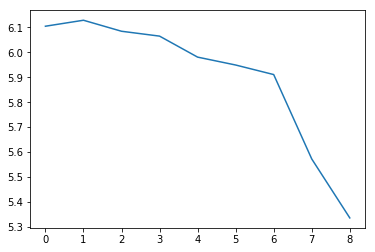

In [38]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

In [39]:
# as we see generator produces very similar vectors 
fake_rows[:,:9]

tensor([[4.7839, 1.3372, 1.5696, 0.3010, 3.4508, 2.9964, 1.8445, 0.5438, 2.5319],
        [4.7814, 1.3440, 1.5614, 0.3005, 3.4848, 2.9974, 1.8390, 0.5465, 2.5136],
        [4.7851, 1.3195, 1.5691, 0.2962, 3.4672, 3.0037, 1.8446, 0.5386, 2.5608],
        [4.7865, 1.3228, 1.5674, 0.2956, 3.4987, 3.0116, 1.8382, 0.5415, 2.5436],
        [4.7728, 1.3346, 1.5653, 0.3049, 3.4598, 2.9856, 1.8475, 0.5580, 2.5524],
        [4.7883, 1.3013, 1.5608, 0.2855, 3.4821, 3.0073, 1.8286, 0.5240, 2.5446],
        [4.7800, 1.3553, 1.5673, 0.3034, 3.4711, 3.0002, 1.8441, 0.5500, 2.5217],
        [4.7758, 1.3597, 1.5698, 0.3123, 3.4438, 2.9835, 1.8499, 0.5577, 2.5273],
        [4.7905, 1.3076, 1.5613, 0.2919, 3.4790, 3.0230, 1.8180, 0.5317, 2.5509],
        [4.7840, 1.3282, 1.5661, 0.2939, 3.4696, 2.9958, 1.8501, 0.5365, 2.5545],
        [4.7814, 1.3119, 1.5574, 0.2974, 3.4828, 3.0047, 1.8491, 0.5453, 2.5302],
        [4.7870, 1.3177, 1.5767, 0.2928, 3.4848, 2.9970, 1.8488, 0.5350, 2.5593],
        [4.7873,

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.init as init
from os.path import isfile, isdir, join
import os
# from tensorboard_logger import configure, log_value

In [42]:
lrD = 5e-4
lrG = 5e-4
batch_size = 100
cuda = True
epochs = 300 #change
device = 5
seed = 1
nz = 10
d_iter = 5
g_iter = 1
lamba = 1e-2 # constant for L2 penalty (diversity)
name = "mnist-experiment"
# configure("runs/run-" + args.name, flush_secs=5)
torch.manual_seed(seed)


# data_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#     transform=transforms.Compose([
#     transforms.ToTensor(),
#     ])), batch_size=batch_size, shuffle=True)

In [43]:
# length=6
# batch_size=5

In [44]:
features_length

NameError: name 'features_length' is not defined

In [45]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(features_length, 1024)
        # bottom
        self.b1 = torch.nn.Linear(features_length, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, features_length)
    def forward(self, xr, xf):
        # get filt
        filt = (torch.abs((real != 0).float() * fake - real))/real.shape[0]
#         filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())
#         filt = torch.abs((xr != 0).int() * xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
#         print(filt.type(), x.type())
        x = filt * x

        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x
        
# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, features_length),
#     torch.nn.Sigmoid()*5
#     )

class NetG(nn.Module):
    
    def __init__(self):

        super(NetG, self).__init__()

        self.net = nn.Sequential(
                                 nn.Linear(nz,1024),
                                 nn.ReLU(),
                                 nn.Linear(1024,features_length),
                                 nn.Sigmoid(),
                                 nn.Dropout(0.5)
                                    )
        
    def forward(self, x):
        x = self.net(x)
        return x*5 # to get values in range [0,5]
    
# networks
netD = NetD(use_cuda=False)
netG = NetG()
print(netG)
print(netD)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
one = torch.FloatTensor([1])
mone = one * -1

NetG(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3706, bias=True)
    (3): Sigmoid()
    (4): Dropout(p=0.5)
  )
)
NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)


In [46]:
one = torch.FloatTensor([1])
mone = one * -1
cuda = False
if cuda is True:
    netD.cuda()
    netG.cuda()
    one, mone = one.cuda(), mone.cuda()

In [47]:
for p in netD.parameters(): # reset requires_grad
    p.requires_grad = True #
    
for p in netG.parameters(): # reset requires_grad
    p.requires_grad = True #

In [48]:
# batch_size = 5

In [49]:
def getRealSample(length=6):
     return Variable(torch.IntTensor(np.random.choice([0, 1], size=(batch_size, length))))

In [50]:
get_random_batch(train, batch_size=batch_size).shape

torch.Size([100, 3706])

In [51]:
steps_per_epoch = 100
gen_iterations = 0
eval_losses = []
for epoch in range(epochs):
#     data_iter = iter(data_loader)
    i = 0
    while i < steps_per_epoch:
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        d_iter = d_iter
        j = 0
        while j < d_iter:
            j += 1
            # load real data
            i += 1
#             X, _ = data_iter.next()
            X = get_random_batch(train, batch_size=batch_size)
#             print(X >= 0.5)
# #             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            # generate fake data
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
#             print(real.shape, fake.shape)
    
            # compute gradient, take step
            netD.zero_grad()
#             print('real', real)
#             print('fake', fake[:,0].sum())
            out = netD(real, fake)
            
            outputD = torch.mean(out) + lamba * out.norm()
            stdD = torch.std(out)
            outputD.backward(mone)
            optimizerD.step()
#             print(out.shape)
        ############################
        # (2) Update G network
        ###########################
        g_iter = g_iter
        j = 0
        while j < g_iter:
            j += 1
            for p in netD.parameters():
                p.requires_grad = False # to avoid computation
            netG.zero_grad()
            
            # load real data
            i += 1
            X = get_random_batch(train, batch_size=batch_size)
#             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            
            # update generator
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            noisev = Variable(noise)
            fake = netG(noisev)
            out = netD(real, fake)
            outputG = torch.mean(out) + lamba * out.norm()
            stdG = torch.std(out)
            outputG.backward(one)
            optimizerG.step()

            gen_iterations += 1

#             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
#             print('output_D', outputD.item(), gen_iterations)
#             print('output_G', outputG.item(), gen_iterations)
#             print('std_D', stdD.item(), gen_iterations)
#             print('std_G', stdG.item(), gen_iterations)
            
            # evaluation
            if gen_iterations % 100 == 0: # todo- to change
#                 gen.eval()
#                 z_vector_eval = make_some_noise(128)
#                 fake_rows_eval = gen(z_vector_eval)
#                 real_rows_eval = get_random_batch(train, 128)
        #         print(fake_rows[0][:10]) enable to see some results
                eval_loss = F.mse_loss(fake, real, reduction='mean')
                eval_losses.append(eval_loss)
                print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real, fake)))
#                 print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))

Epoch number 5. my distance between random real and fake samples 30489.251953125
Epoch number 11. my distance between random real and fake samples 39576.18359375
Epoch number 17. my distance between random real and fake samples 36241.203125
Epoch number 23. my distance between random real and fake samples 27993.5
Epoch number 29. my distance between random real and fake samples 28787.44921875
Epoch number 35. my distance between random real and fake samples 24984.685546875
Epoch number 41. my distance between random real and fake samples 40185.18359375
Epoch number 47. my distance between random real and fake samples 35311.5546875
Epoch number 52. my distance between random real and fake samples 27436.328125
Epoch number 58. my distance between random real and fake samples 28843.56640625
Epoch number 64. my distance between random real and fake samples 28300.921875
Epoch number 70. my distance between random real and fake samples 27582.216796875
Epoch number 76. my distance between ran

In [52]:
# torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda()).cuda().type()
torch.abs((real != 0).float() * fake - real).type()

'torch.FloatTensor'

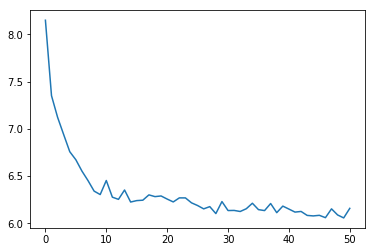

In [53]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

In [54]:
batch_size = ratings.shape[0]
batch_size

6040

In [55]:
noise = torch.randn(batch_size, nz)
if cuda: 
    noise = noise.cuda()
noisev = Variable(noise)
fake = netG(noisev)

In [56]:
print(5, (5 == fake.round()).sum(), (5 == ratings.round()).sum())
print(4, (4 == fake.round()).sum(), (4 == ratings.round()).sum())
print(3, (3 == fake.round()).sum(), (3 == ratings.round()).sum())
print(2, (2 == fake.round()).sum(), (2 == ratings.round()).sum())
print(1, (1 == fake.round()).sum(), (1 == ratings.round()).sum())
print(0, (0 == fake.round()).sum(), (0 == ratings.round()).sum())

5 tensor(435426) 226310
4 tensor(4807224) 348971
3 tensor(4499286) 261197
2 tensor(1158403) 107557
1 tensor(193166) 56174
0 tensor(11191494) 21384031


In [75]:
# 11191494 > 21384031
fake_ratings = fake.detach().int().numpy().round()

In [76]:
fake_ratings

array([[4, 0, 0, ..., 3, 0, 3],
       [4, 3, 0, ..., 3, 3, 3],
       [3, 3, 2, ..., 3, 0, 0],
       ...,
       [4, 3, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 3, 3, 3],
       [0, 0, 2, ..., 0, 3, 0]])

In [77]:
# 11191494 > 21384031
fake_ratings.shape, ratings.shape

((6040, 3706), (6040, 3706))

In [79]:
get_sparsity(fake_ratings)

6040 users
3706 items


49.93718795009346

In [80]:
get_sparsity(ratings.round())

6040 users
3706 items


4.468362562231285

In [81]:
adding_fake = fake_ratings[:300]

In [88]:
adding_fake[:,0]

array([4, 4, 3, 0, 4, 3, 4, 0, 0, 0, 4, 4, 4, 3, 0, 4, 4, 4, 4, 4, 0, 0,
       4, 0, 4, 0, 4, 0, 0, 0, 0, 4, 4, 4, 4, 3, 4, 3, 4, 3, 3, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 4, 3, 4, 4, 0, 4, 4, 4, 4, 4,
       0, 4, 4, 3, 4, 0, 3, 4, 0, 4, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 4, 4,
       4, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 4, 3,
       3, 4, 0, 0, 3, 3, 3, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 0,
       4, 0, 0, 3, 4, 3, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 0, 3, 4, 4, 0, 4, 0, 0, 0, 4, 3, 4, 4, 4, 0, 0, 4, 3, 4,
       4, 0, 0, 0, 0, 4, 0, 4, 4, 3, 4, 4, 0, 4, 0, 4, 0, 0, 0, 4, 4, 0,
       3, 0, 0, 4, 4, 4, 3, 0, 4, 4, 0, 3, 0, 4, 4, 0, 0, 0, 4, 4, 4, 4,
       4, 0, 4, 0, 0, 0, 4, 4, 3, 0, 0, 0, 0, 4, 4, 0, 3, 0, 0, 4, 0, 0,
       0, 0, 4, 3, 0, 0, 4, 4, 0, 0, 4, 4, 4, 3, 3, 0, 0, 0, 0, 4, 0, 4,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 4, 3,
       4, 0, 0, 0, 3, 0, 0, 4, 4, 4, 0, 0, 4, 0])

In [87]:
adding_fake[:,3]

array([0, 0, 3, 3, 0, 0, 0, 3, 3, 3, 0, 3, 3, 2, 3, 0, 3, 0, 0, 3, 3, 3,
       0, 0, 0, 3, 3, 3, 3, 3, 0, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0,
       3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 2, 0, 3, 3, 0, 0, 2, 0,
       2, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 0, 0, 3, 0,
       0, 3, 2, 3, 2, 3, 0, 0, 3, 3, 3, 0, 3, 0, 0, 3, 2, 3, 3, 3, 3, 2,
       0, 3, 0, 0, 0, 3, 0, 3, 3, 0, 3, 2, 0, 3, 3, 0, 0, 0, 3, 0, 0, 3,
       3, 3, 0, 2, 0, 0, 3, 3, 2, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3,
       3, 0, 3, 3, 2, 3, 2, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 2, 0,
       3, 0, 0, 3, 3, 0, 3, 3, 0, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 3, 3, 0,
       2, 3, 0, 3, 3, 3, 3, 0, 0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3,
       3, 3, 2, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 0, 0, 3, 3, 0, 0,
       0, 2, 3, 0, 0, 0, 3, 3, 3, 2, 0, 0, 3, 0, 2, 3, 2, 3, 3, 0, 3, 3,
       3, 3, 0, 3, 0, 0, 2, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2,
       0, 3, 0, 3, 3, 3, 0, 3, 0, 0, 2, 2, 3, 3])

In [89]:
ratings.shape, adding_fake.shape

((6040, 3706), (300, 3706))

In [100]:
new_mat = np.append(ratings, adding_fake, axis=0)

In [101]:
new_mat.shape

(6340, 3706)

In [104]:
get_sparsity(new_mat)

6040 users
3706 items


6.622056312467974

In [102]:
(fake[0] < 1).sum()

tensor(1890)

In [103]:
(ratings[0] < 1).sum()

3653

In [ ]:
fake.shape

In [ ]:
(4 == fake.round()).sum()

In [ ]:
(3 == fake.round()).sum()

In [ ]:
(2 == fake.round()).sum()

In [ ]:
(1 == fake.round()).sum()

In [ ]:
(0 == ratings.round()).sum()

In [ ]:
(3 == ratings.round()).sum()

In [ ]:
(5 == ratings.round()).sum()

In [ ]:
(4 == ratings.round()).sum()

In [ ]:
batch_size

In [ ]:
def random_row(n=10):
    elements = [0, 1, 2, 3, 4, 5]
    probabilities = [0.5, 0.1, 0.1, 0.1, 0.1, 0.1]
    return np.random.choice(elements, 10, p=probabilities)

In [ ]:
random_row(n=10)

In [ ]:
def d_dwgan(x_r, x_g):
    return sum(x_r != x_g)

In [ ]:
def d_my(x_r, x_g):
    return np.sum(np.abs((x_r != 0).astype(int) * x_g - x_r))

In [ ]:
d_my(x_r_2, x_g_2)

In [ ]:
x_r_1 = np.array([0, 0, 4, 0, 5, 0, 0, 0, 0, 0])
x_g_1 = np.array([0, 0, 3, 0, 4, 0, 0, 0, 0, 0])

x_r_2 = np.array([0, 0, 4, 0, 5, 0, 0, 0, 0, 0])
x_g_2 = np.array([0, 5, 3, 0, 4, 4, 0, 0, 0, 0])

In [ ]:
x_r_1, x_g_1

In [ ]:
x_r_2, x_g_2

In [ ]:
d_dwgan(x_r_1, x_g_1)

In [ ]:
d_dwgan(x_r_2, x_g_2)

In [ ]:
d_my(x_r_1, x_g_1)

In [ ]:
d_my(x_r_2, x_g_2)

In [ ]:
x_r = random_row(n=10)
x_g = random_row(n=10)

print('x real', x_r)
print('x gen ', x_g)

In [ ]:
d_dwgan(x_r, x_g)

In [ ]:
d_my(x_r, x_g)